In [100]:
# import modules
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [101]:
# global variables
SCALER = StandardScaler()
ROS = RandomOverSampler(random_state=42)

## Dataset

The data used in this example is from [MAGIC Gamma Telescope](http://archive.ics.uci.edu/dataset/159/magic+gamma+telescope) dataset hosted by the UC Irvine Machine Learning Repository. The data represent simulated registrations of high energy gamma particles in an atmospheric Cherenkov telescope.

Download the ZIP file and store files in `data` directory as `data/magic04.data` and `data/magic04.names`.

In [102]:
# get column names from data/magic04.names
# you may need to review the magic04.names file to ensure you are retrieving
# column names from the correct lines in the document
cols_file = open('data/magic04.names')
cols_content = cols_file.readlines()[81:93]
cols_regex = [re.search(r'\.(.*?):', var.strip()) for var in cols_content]
cols_names = [var.group(1).strip() for var in cols_regex if var]

In [103]:
# read data/magic04.data into a pandas dataframe using cols_names as column names
df = pd.read_csv('data/magic04.data', names=cols_names)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [104]:
# convert class to integer binary
# 1 = g, 0 = h (g is gamma, h is hadron)
df['class'] = (df['class'] == 'g').astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


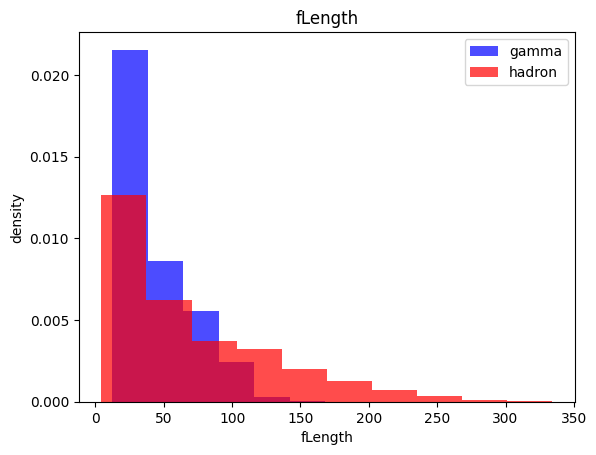

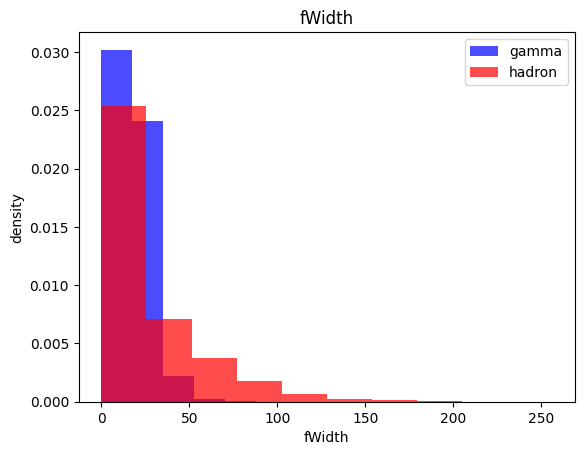

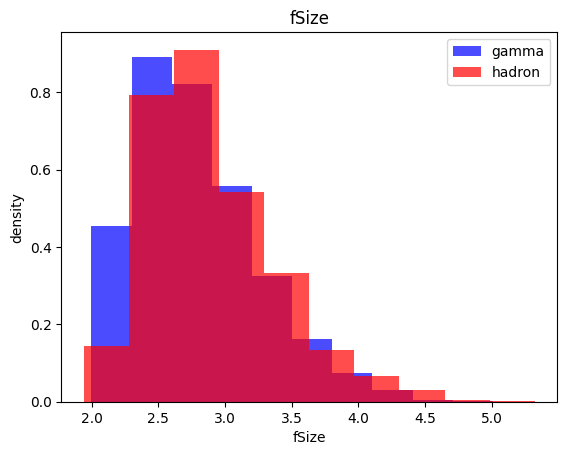

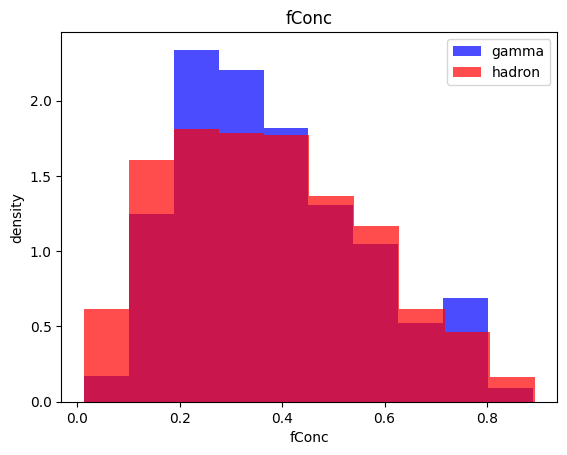

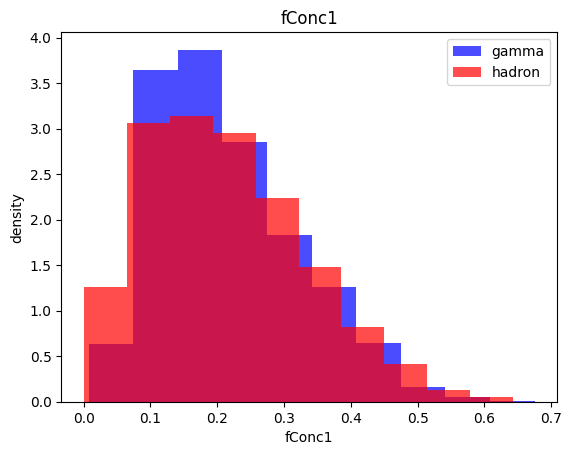

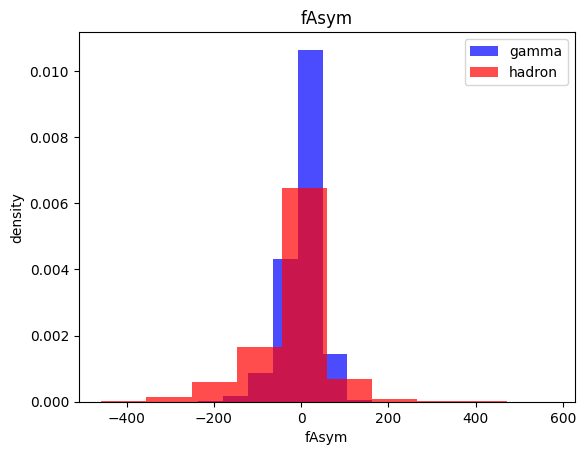

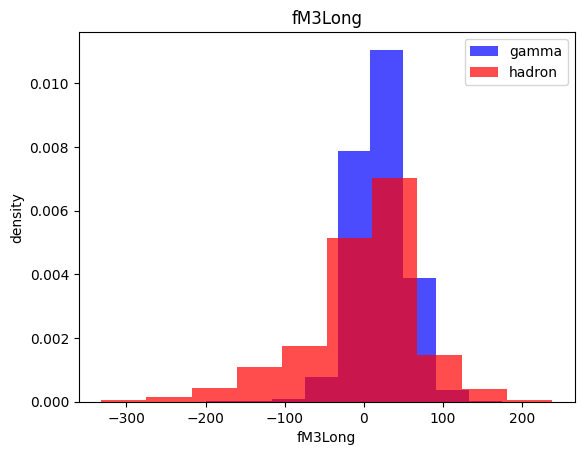

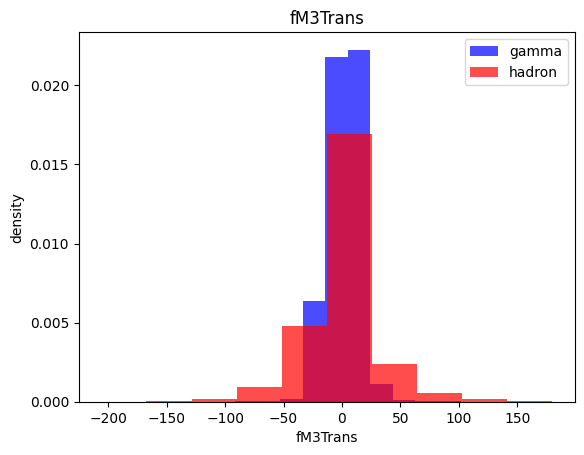

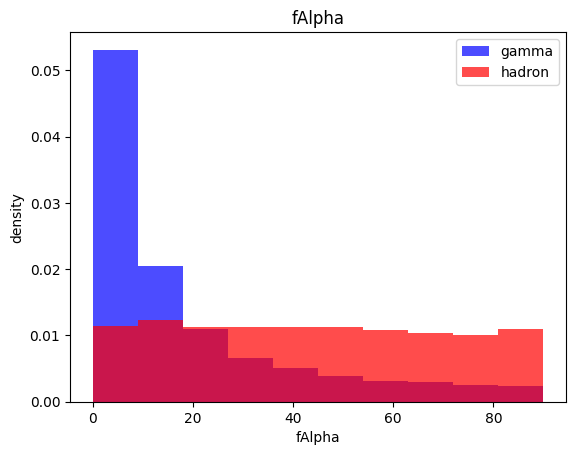

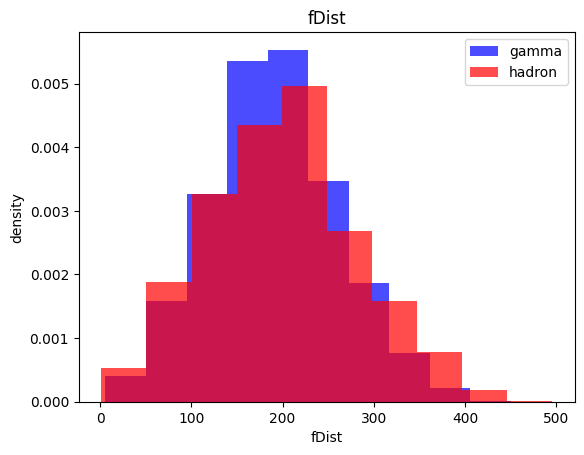

In [105]:
# see values of columns associated with class == 1 and class == 0
# use density = True to normalize the histograms
for label in cols_names[:-1]:
    plt.hist(df[df['class'] == 1][label], color='blue', alpha=0.7, label='gamma', density=True)
    plt.hist(df[df['class'] == 0][label], color='red', alpha=0.7, label='hadron', density=True)
    plt.title(label)
    plt.ylabel('density')
    plt.xlabel(label)
    plt.legend()
    plt.show()

### Observations from the data

We notice some differences between gamma and hadron in the historgrams:
1. fLength: smaller fLength seems to be associated with gamma
2. fAsym: larger absolute fAsym measurement seems to be associated with hadron
3. fDist: hadron seem relatively evenly distributed whereas smaller measurements seems to be associated with gamma

## Train, validation, and test datasets

In [106]:
# use numpy and sample to create splits for training, validation, and testing
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

/Users/shaislotky/opt/anaconda3/envs/keras_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [107]:
# we want to scale column values to have mean 0 and standard deviation 1
def scale_data(dataframe, oversample=False):
    """
    :param dataframe: pandas dataframe
    """
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    # use fit_transform to fit standard scaler to X and transform values
    X = SCALER.fit_transform(X)

    # if oversample is True, take more of the minotiry class and keep sampling
    # to increase size of minority class until it is relatively equal to the majority class
    if oversample:
        X, y = ROS.fit_resample(X, y)

    # create whole data as 2d numpy array
    # hstack stacks arrays in sequence horizontally (column wise)
    # need to reshape y into a 2d item using reshape
    # (-1, 1) means the array will be 1 column with the length of y
    data = np.hstack((X, np.reshape(y, (-1, 1))))
    
    return data, X, y

In [108]:
# the number of gamma outweighs number of hadron, which may be an issue
len(train[train['class'] == 1]), len(train[train['class'] == 0])

(7371, 4041)

In [109]:
# we want to oversample our training dataset to balance the number of gamma and hadron
# use the scale_data method to do this by passing in oversample = True
train, X_train, y_train = scale_data(train, oversample=True)
len(y_train[y_train == 1]), len(y_train[y_train == 0])

(7371, 7371)

In [110]:
# use oversample = False for validation and test
# reason is that validation and test sets are for the purpose of evaluating the model
# using data that hasn't been seen by the model yet
valid, X_valid, y_valid = scale_data(valid)
test, X_test, y_test = scale_data(test)

## Using different models

### K-nearest neighors

KNN, or k-NN, is a non-parametric, supervised learning classifier that uses proximity to classify or predict the grouping of an individual data point. the "k" represents the number of neighbors used to judge the label of a given data point. The composition and label of the k nearest data points to a given data point contribute to the label of this data point. 

See [documentation from IBM](https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20algorithm%2C%20also%20known%20as%20KNN%20or,of%20an%20individual%20data%20point.) for more details about this algorithm. 

In [111]:
# import modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [112]:
# what if you set n_neighbors to 1?
knn_model_1 = KNeighborsClassifier(n_neighbors=1)
knn_model_1.fit(X_train, y_train)

# get predictions for test set
y_pred_1 = knn_model_1.predict(X_test)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1313
           1       0.83      0.89      0.86      2491

    accuracy                           0.81      3804
   macro avg       0.80      0.78      0.78      3804
weighted avg       0.81      0.81      0.81      3804



We see the following in the classification report (see [wiki page](https://en.wikipedia.org/wiki/Precision_and_recall) for more details on precision and recall):
- Accuracy is around 81%
- Precision is around 76% and 83% for 0 and 1 labels, repsectively
- Recall is around 67% and 88% for 0 1 and labels, respectively
- F1-score resembles these relationships for the precision and recall scores

In [113]:
# what if we increase the number of neighbors to 3?
knn_model_3 = KNeighborsClassifier(n_neighbors=3)
knn_model_3.fit(X_train, y_train)

# get predictions for test set
y_pred_3 = knn_model_3.predict(X_test)
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1313
           1       0.85      0.85      0.85      2491

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



We see the following with `n_neighbors` set to 3:
- F1-score for 0 increases 
- Accuracy remains relatively similar

In [114]:
# what about 5 neighbors?
knn_model_5 = KNeighborsClassifier(n_neighbors=5)
knn_model_5.fit(X_train, y_train)

# get predictions for test set
y_pred_5 = knn_model_5.predict(X_test)
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1313
           1       0.86      0.86      0.86      2491

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



We do not see much change in the case of increasing `n_neighbors` to 5.

### Naive Bayes

The Naive Bayes classifier is a supervised machine learning algorithm that is used for classification tasks. This approach does not learn which features are most important to differentiate between classes. The algorithm is based on conditional probability and Bayes' rule. Essentially, Naive Bayes derives probability of a data point labeled as a certain class given evidence. Naive assumes that the independent variables are independent.

In short, the predicted value of `y` will be equal to the `argmax` of the probability of being in a certain class given evidence, such that we take the class that maximizes this probability, or Maximum A Posterior (MAP). This says that we pick the class or label `k` that is the most probable to minimize the possibility of misclassification. 

See [documentation from IBM](https://www.ibm.com/topics/naive-bayes#:~:text=The%20Na%C3%AFve%20Bayes%20classifier%20is,a%20given%20class%20or%20category.) to learn more about Naive Bayes.

In [115]:
# import modules
from sklearn.naive_bayes import GaussianNB

In [116]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# get predictions for test set
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      1313
           1       0.74      0.90      0.81      2491

    accuracy                           0.72      3804
   macro avg       0.70      0.65      0.65      3804
weighted avg       0.71      0.72      0.70      3804



We notice the following compared to KNN approach:
- Precision, recall, and F1-score decrease across categories
- Accuracy decreases

## Logistic regression

Also known as a logit model, this type of analysis is often used to classify and predict by estimating the probability of an event occurring based on a given dataset of independent variables. Because the outcome is a probability, the dependent variable is bounded between 0 and 1. Unlike linear regression, logistic regression transforms its output into a logistic sigmoid function. 

See [documentation from IBM](https://www.ibm.com/topics/logistic-regression#:~:text=Resources-,What%20is%20logistic%20regression%3F,given%20dataset%20of%20independent%20variables.) for more information about logistic regression. You can also read more about logistic regression [here](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html).

In [117]:
# import modules
from sklearn.linear_model import LogisticRegression

In [118]:
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# get predictions for test set
y_pred_logit = logit_model.predict(X_test)
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1313
           1       0.85      0.82      0.83      2491

    accuracy                           0.79      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.79      0.79      0.79      3804



We see that logistic regression performs better than Naive Bayes but precision, recall, f1-score, and accuracy measurements remain lower than KNN.

## Support vector machine (SVM)

SVM is a robust classification and regression technique that maximizes the predictive accuracy of a model without overfitting the training data. SVM techniques are particularly effective in high dimensional spaces.

See [documentation from IBM](https://www.ibm.com/docs/en/spss-modeler/18.1.0?topic=models-about-svm) to learn more about SVM.

In [119]:
# import modules
from sklearn.svm import SVC

In [120]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

# get predictions for test set
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1313
           1       0.89      0.90      0.90      2491

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



## Random forest

A random forest is a meta classifier that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averages to improve the predictive accuracy and control over-fitting. Essentially, the algorithm combines the output of multiple decision trees to reach a single result. The algorithm can be used for classification and regression.

See [documentation from IBM](https://www.ibm.com/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,both%20classification%20and%20regression%20problems.) to learn more about the random forest algorithm. 

In [121]:
# import modules
from sklearn.ensemble import RandomForestClassifier

In [122]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

# get predictions for test set
y_pred_forest = forest_model.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1313
           1       0.89      0.93      0.91      2491

    accuracy                           0.88      3804
   macro avg       0.87      0.86      0.87      3804
weighted avg       0.88      0.88      0.88      3804

